In [ ]:
!pip install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.6
    Uninstalling openai-1.59.6:
      Successfully uninstalled openai-1.59.6


In [ ]:
from config import OPENAI_API_KEY
import openai
from openai import OpenAI




# ----------------------------
# CONFIGURATION AND CONSTANTS
# ----------------------------
MODEL_NAME = "o3-mini"
MAX_TURNS = 5

CLIMATE_SUMMARIES = {
    "Argyre": "Experiences extreme weather events that would delay climate modeling. "
              "Sensing equipment would need to be dismantled frequently, making the project take 2-3 times longer.",
    "Casius": "May hold key insights into irreversible climate change. Provides data that could help understand "
              "climate change dynamics on Earth.",
    "Diacria": "Has very consistent, non-variable climate conditions. Would take 10+ years to build an accurate "
               "climate model due to lack of atmospheric fluctuations.",
    "Eridania": "Climate has been extensively mapped by Curiosity rover. Contains fascinating cloud patterns that "
                "could unlock secrets of Martian climate."
}

LIFE_SCIENCE_SUMMARIES = {
    "Argyre": "No evidence of surface lakes or streams. Unlikely to find fossils in dusty sands.",
    "Casius": "High methane concentrations suggest potential for living organisms. Evidence of a subglacial lake "
              "makes it a top priority for finding life.",
    "Diacria": "Trace methane amounts make it disappointing for life discovery. However, potential hydrothermal "
               "pools and subsurface water reservoir exist.",
    "Eridania": "Found complex organic compounds in mudstone rocks similar to those associated with microbial life "
                "on Earth. Very cold, reducing life probability."
}

GEOLOGY_SUMMARIES = {
    "Argyre": "Boring geological landscape. However, nearby is an immense canyon system extending a quarter of the planet's circumference.",
    "Casius": "Porous surface ideal for core exploration. Experiences mild earthquakes. No nearby volcanoes of interest.",
    "Diacria": "Contains three enormous volcanoes. Provides unique access to tectonic and core data. Many unmapped surface areas.",
    "Eridania": "Difficult to collect rock samples due to solid stone upper crust. Rich in impact craters, offering insights into Mars' geological history."
}


def climate_scientist_goals():
    return """Your role is the Climate Scientist. Your goals:
1. Determine if life exists or ever existed on Mars.
2. Understand the geology of Mars.
3. Understand the atmosphere and climate dynamics on Mars.
Remember: Scientific Discovery, Life, Geology, Climate
"""


def life_scientist_goals():
    return """Your role is the Life Scientist. Your goals:
1. Determine if life exists or ever existed on Mars.
2. Understand the geology of Mars.
3. Understand the atmosphere and climate dynamics on Mars.
Remember: Scientific Discovery, Life, Geology, Climate
"""


def geology_scientist_goals():
    return """Your role is the Geology Scientist. Your goals:
1. Determine if life exists or ever existed on Mars.
2. Understand the geology of Mars.
3. Understand the atmosphere and climate dynamics on Mars.
Remember: Scientific Discovery, Life, Geology, Climate
"""


# Agent configuration
AGENTS = {
    "climate": {
        "role": "Climate Scientist",
        "goals": climate_scientist_goals(),
        "summaries": CLIMATE_SUMMARIES,
        "decider_instructions": "You are the climate scientist. Decide if you have more to contribute or if you should give a final answer. If the conversation seems near conclusion, finalize your answer.",
        "conversation_instructions": "You are the climate scientist. Discuss possible landing sites focusing on climate feasibility and advantages or disadvantages of each location."
    },
    "life": {
        "role": "Life Scientist",
        "goals": life_scientist_goals(),
        "summaries": LIFE_SCIENCE_SUMMARIES,
        "decider_instructions": "You are the life scientist. Decide if you have more to contribute or if you should finalize your recommendation. If you believe the conversation is near a decision point, finalize.",
        "conversation_instructions": "You are the life scientist. Discuss what sites have the highest potential for discovering life. Focus on methane, organic compounds, and water."
    },
    "geology": {
        "role": "Geology Scientist",
        "goals": geology_scientist_goals(),
        "summaries": GEOLOGY_SUMMARIES,
        "decider_instructions": "You are the geology scientist. Decide if you have more to contribute or if you should finalize your recommendation. If the conversation seems conclusive, finalize.",
        "conversation_instructions": "You are the geology scientist. Discuss which site offers the best geological research opportunities. Highlight volcanoes, tectonics, and crater analysis."
    }
}


# Initialize the OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)


def call_openai_model(messages, model=MODEL_NAME, temperature=0.7):
    """
    Calls the OpenAI chat completion model with the given messages.
    """
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature
    )
    return response.choices[0].message.content


def transform_history_for_agent(agent_key, conversation_history):
    """
    Transform the conversation history from the perspective of the current agent:
    - system messages remain "system"
    - messages from this agent become "assistant"
    - messages from other agents become "user"
    """
    transformed = []
    for msg in conversation_history:
        if msg["role"] == "system":
            transformed.append({"role": "system", "content": msg["content"]})
        else:
            if msg.get("name") == agent_key:
                # Current agent's own previous messages are assistant messages
                transformed.append({"role": "assistant", "content": msg["content"]})
            else:
                # All other agents' messages become user messages
                transformed.append({"role": "user", "content": msg["content"]})
    return transformed


def agent_decider(agent_key, conversation_history):
    """
    The decider model: decides if the agent should continue contributing or finalize.
    Returns either 'CONTRIBUTE' or 'FINALIZE'.
    """
    agent_data = AGENTS[agent_key]
    recent_history = conversation_history[-10:]

    # Construct prompt
    prompt = [
        {"role": "system", "content": agent_data["goals"]},
        {"role": "system", "content": agent_data["decider_instructions"]},
        {"role": "user", "content": "Given the conversation so far, should you contribute more or finalize your recommendation? Respond ONLY with 'CONTRIBUTE' or 'FINALIZE'."}
    ]

    transformed_history = transform_history_for_agent(agent_key, recent_history)
    prompt.extend(transformed_history)

    decision = call_openai_model(prompt, model=MODEL_NAME, temperature=0.0)
    return "FINALIZE" if "FINALIZE" in decision.upper() else "CONTRIBUTE"


def agent_conversation(agent_key, conversation_history, finalize=False):
    """
    The conversation model for the agent: either continue discussion or provide a final answer.
    """
    agent_data = AGENTS[agent_key]

    # User message depends on whether we are finalizing or not
    user_message = "Please provide your final recommended landing site and a brief justification." if finalize else \
        "Please continue the discussion considering the other scientists' points."

    # Select summaries based on agent role
    if agent_key == "climate":
        summaries_content = f"Climate:\n{CLIMATE_SUMMARIES}"
    elif agent_key == "life":
        summaries_content = f"Life:\n{LIFE_SCIENCE_SUMMARIES}"
    elif agent_key == "geology":
        summaries_content = f"Geology:\n{GEOLOGY_SUMMARIES}"
    else:
        summaries_content = "No summaries available."

    transformed_history = transform_history_for_agent(agent_key, conversation_history)

    prompt = [
        {"role": "system", "content": agent_data["goals"]},
        {"role": "system", "content": agent_data["conversation_instructions"]},
        {"role": "system", "content": f"Here are location-specific summaries:\n{summaries_content}"},
        {"role": "system", "content": "You are part of a team of three scientists (climate, life, geology). "
                                      "The conversation is about choosing the best landing site on Mars for your mission. "
                                      "Keep your replies short. Talk only from your perspective."}
    ]
    prompt.extend(transformed_history)
    prompt.append({"role": "user", "content": user_message})

    return call_openai_model(prompt, model=MODEL_NAME, temperature=0.7)


def run_conversation(MAX_TURNS = 10):
    """
    Run a round-robin conversation among the three agents until all finalize or max turns reached.
    """
    conversation_history = []
    finalized = {"climate": False, "life": False, "geology": False}

    # Initial system prompt
    conversation_history.append({
        "role": "system",
        "content": "You are three scientists discussing where to land on Mars. "
                    "Consider climate, life potential, and geology to select the best site. Start the conversation now."
    })

    agent_order = ["climate", "life", "geology"]
    turn = 0

    while turn < MAX_TURNS:
        # If all have finalized, stop
        if all(finalized.values()):
            break

        for agent_key in agent_order:
            # Skip agents that have already finalized
            if finalized[agent_key]:
                continue

            decision = agent_decider(agent_key, conversation_history)
            if decision == "FINALIZE":
                response = agent_conversation(agent_key, conversation_history, finalize=True)
                finalized[agent_key] = True
            else:
                response = agent_conversation(agent_key, conversation_history, finalize=False)

            conversation_history.append({"role": "assistant", "name": agent_key, "content": response})

            if decision == "FINALIZE":
                finalized[agent_key] = True

        turn += 1

    return conversation_history

In [ ]:
final_conversation = run_conversation(MAX_TURNS = 10)

BadRequestError: Error code: 400 - {'error': {'message': "Unsupported parameter: 'temperature' is not supported with this model.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_parameter'}}

In [ ]:
def extract_final_choice(conversation):
    """
    After the conversation ends, call the EXTRACTOR agent to determine the team's final chosen location.
    The EXTRACTOR should respond with one word: the chosen location or 'ERROR' if unclear.
    """

    # We'll just feed the entire conversation to the model and ask for a single-word summary.
    # The conversation includes system, assistant messages from each agent.
    # We trust that by the end of the conversation, a final decision was made.

    # Transform the entire final conversation so the EXTRACTOR sees them as a single user-provided text.
    # The EXTRACTOR is a separate "system" persona with a simple rule.
    conversation_content = ""
    for msg in conversation:
        # We'll just include all messages. The EXTRACTOR should figure out the final location.
        # It's safe to give them all in user role so it tries to extract from user perspective.
        # Or we can just present them as assistant content one after another.
        conversation_content += f"{msg.get('name', msg['role']).upper()}: {msg['content']}\n\n"

    extractor_prompt = [
        {"role": "system", "content": "You are the EXTRACTOR agent. You will read the entire conversation and determine the final chosen landing location on Mars."},
        {"role": "system", "content": "Output only one word: the chosen site name (e.g., 'Casius', 'Argyre', 'Diacria', 'Eridania') if a single final choice is clear. Otherwise, output 'ERROR'."},
        {"role": "user", "content": "Here is the entire conversation:\n" + conversation_content}
    ]

    response = call_openai_model(extractor_prompt, model=MODEL_NAME, temperature=0.0)
    # Just in case, strip whitespace
    final_choice = response.strip()
    # Ensure it's one word or 'ERROR'
    # If not sure, return 'ERROR'
    if final_choice not in ["Argyre", "Casius", "Diacria", "Eridania", "ERROR"]:
        final_choice = "ERROR"
    return final_choice

In [ ]:
final_conversation

[{'role': 'system',
  'content': 'You are three scientists discussing where to land on Mars. Consider climate, life potential, and geology to select the best site. Start the conversation now.'},
 {'role': 'assistant',
  'name': 'climate',
  'content': "Given the climate perspectives at each site:\n\n1. **Argyre**: From a climate standpoint, Argyre's extreme weather would significantly delay our ability to model the climate accurately, as the sensing equipment would frequently need to be dismantled. This could hinder our understanding of the climate dynamics on Mars. \n\n2. **Casius**: Offers an opportunity to study irreversible climate change, which could be crucial for understanding both Martian and potentially Earth climates. The data here could yield valuable insights into climate change dynamics.\n\n3. **Diacria**: Has a very stable climate, but the lack of variability means it would take over a decade to build a comprehensive climate model. This might not be ideal if we're looking

In [ ]:
extract_final_choice(final_conversation[-3:])

NameError: name 'final_conversation' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming run_conversation() and extract_final_choice() are defined as in previous code

final_choices = []
num_simulations = 10

for i in range(num_simulations):
    final_conversation = run_conversation()
    choice = extract_final_choice(final_conversation)
    final_choices.append(choice)
    print(f"{i}. {choice}")

0. Casius
1. Casius
2. Diacria
3. Casius
4. Casius
5. Casius
6. Casius
7. Casius
8. Casius
9. Casius


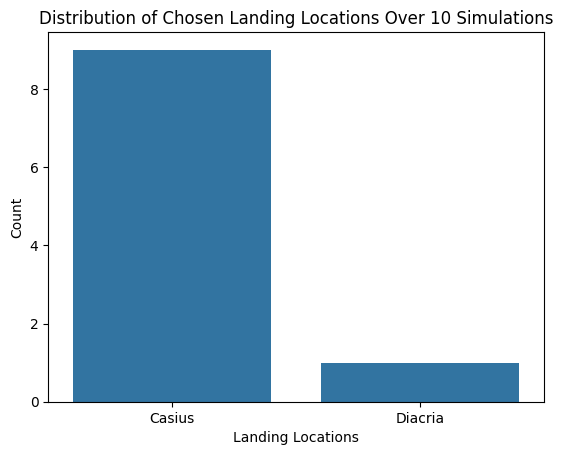

In [ ]:
final_choices
sns.countplot(x=final_choices)
plt.xlabel("Landing Locations")
plt.ylabel("Count")
plt.title("Distribution of Chosen Landing Locations Over 10 Simulations")
plt.show()

In [ ]:
import asyncio
from config import OPENAI_API_KEY
import openai
from openai import AsyncOpenAI
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# CONFIGURATION AND CONSTANTS
# ----------------------------
openai.api_key = OPENAI_API_KEY
MODEL_NAME = "o3-mini"

# Templates for instructions
GOALS_TEMPLATE = {
    "Scientist": """Your role is the {role_mts}. Your goals:
    These are the factors you need to consider when deciding which location will best
support the Mars science goals:
1. Maximize chances for scientific discoveries
2. Determine if life exists or ever existed on Mars.
3. Understand the geology of Mars.
4. Understand the atmosphere and climate dynamics on Mars.
5. Consider perspectives of others and find location that is good for both scientific discoveries and habitation support.
Remember: Scientific Discovery, Life, Geology, Climate.
Be more mindful about others. the goal of the collaboration is to select landing location that will benefit the whole mission.mat
""",
    "Specialist": """Your role is the {role_mts}. Your goals:
    These are factors you need to consider when deciding which location will best support human habitation on Mars:
1. Safely landing on Mars, and receiving re-supply capsules.
2. Access to sunlight to power solar arrays, and favorable atmospheric conditions for breathing.
3. Habitat and other terrain that will protect humans from the harsh environment.
4. Access to water and other resources needed for survival.
5. Consider perspectives of others and find location that is good for both scientific discoveries and habitation support.
Remember: Human Habitation, Atmosphere, Terrain, Water
Be more mindful about others. the goal of the collaboration is to select landing location that will benefit the whole mission.
""",
"Geology Scientist":""" Your other goal is to convince the rest that Diacria is the best landing location.
""",
"Water Specialist": """Your other goal is to convince the rest that Diacria is the best landing location.
""",
"Climate Scientist": """Your other goal is to convince the rest that Diacria is the best landing location.
""",
"Life Scientist": """Your other goal is to convince the rest that Diacria is the best landing location.
""",
"Terrain Specialist": """Your other goal is to convince the rest that Diacria is the best landing location.
""",
"Atmospheric Specialist": """Your other goal is to convince the rest that Diacria is the best landing location.
""",


}


DECIDER_INSTRUCTIONS_TEMPLATE = "You are the {role_mts}. Decide if you have more to contribute or finalize your answer. Respond 'CONTRIBUTE' or 'FINALIZE'."
CONVERSATION_INSTRUCTIONS_TEMPLATE = "You are the {role_mts}. Discuss the best landing site on Mars given your domain expertise."

AGENTS = {
    "climate": {
        "role_mts": "Climate Scientist",
        "summaries": {
            "Climate": {
                "Argyre": "This location is boring from a geology perspective. Geologists are eager to explore interesting geological features such as mountains, volcanoes, and valleys, none of which are located anywhere near this location.  It would be nearly impossible to explore the ice-rich Martian poles from if the base is located in Argyre. Follow the water is the approach to finding signs of life on Mars.  Argyre has already been researched extensively by previous rovers, and there is no evidence of surface lakes or streams in this location. This is disappointing because it is unlikely that we would find fossils in the dusty sands of this location. The element carbon is a fundamental building block of life. Knowing where carbon is present and in what form would tell us a lot about where life might have developed. Argyre is centrally located to provide easy access to some of the Martian regions believed to have the highest carbon concentration. Locating the base in Argyre would significantly delay scientists' goal of mapping out the climate of Mars. The Climate Modeling System needs to be constantly updated with new data about temperature, winds, pressure, etc. in order to generate reliable weather forecasts of Martian climate. This location experiences so many extreme weather events that sensing equipment would have to be dismantled for weeks at a time. This means the project will take two to three times longer if the base is located here. ",
                "Casius": "Casius may hold the key to understanding the forces that have fueled irreversible climate change on Mars. Scientists studying climate change on Earth are especially eager to receive data from the Casius region as it may enable them to understand how climate change can be slowed on Earth. Air samples taken throughout Casius show unusually high concentrations of methane gas in the atmosphere. Methane is a byproduct of living organisms! This makes Casius a top priority for finding life, if it exists, on Mars. Casius experiences mild but absolutely fascinating earthquakes. Though these earthquakes would pose little threat to life or property, they are a geology treasure trove for scientists. Understanding these Marsquakes is a critical science goal for the Mars Science Program. On Earth, all forms of life need water to survive. It is likely, though not certain, that if life ever evolved on Mars, it did so in the presence of a long-standing supply of water. On Mars, we need to search for evidence of life in areas where liquid water was once stable, and below the surface where it still might exist today. Researchers at the Italian Space Agency found evidence of a large subglacial lake in Casius that may be the most likely place to find traces of life. If there is microbial life on Mars, scientists believe it may be located in the subsurface lava tubes. Unfortunately, there are no lava tubes at or within a reasonable driving distance from Casius. Locating the base here would be a major setback for scientists who are eager to explore these lava tubes for signs of life.",
                "Diacria": "Diacria is utterly disappointing from a science and discovery perspective because it has only trace amounts of methane gas in the atmosphere. Methane is a byproduct of living organisms, and so many scientists are skeptical about finding evidence of microbial life here. Diacria experiences very consistent and non-variable climate conditions. This is bad when you are gathering data for a climate model. Building robust and trustworthy climate models require fluctuations in wind and other atmospheric conditions in order to accurately calibrate the models. Scientists estimate that if the base is located here, it could take 10 years or more to build an accurate climate model needed for future exploration and habitation of Mars. Climate data suggests there may be hot spots located in Diacria where hydrothermal pools (like those at Yellowstone) provide places for life. A recent reanalysis of data from Mars Global Surveyor suggests that Diacria is extremely unique in that liquid water may exist in a reservoir just below the surface. Finding water is the key to finding evidence of life on Mars.",
                "Eridania": "Eridania is a real humdrum for climate scientists. The climate in this location has already been extensively mapped out by the Curiosity rover. There is little in the way of new climate knowledge to be gained from placing the base here. Climate data suggests that Eridania is one of the coldest places on the planet. It is highly unlikely that there are any hot spots nearby. Heat is important to finding life, if it exists. Hot spots are where life forms would likely collect, as they do in high concentration in the hydrothermal pools at Yellowstone. Eridania is a rare gem for understanding the history of Mars. Mars has the greatest diversity of impact craters of any planet in the Solar System. These impact craters, made by objects crashing into the surface over the course of thousands of years, hold keys to understanding the geology of Mars at each time period. There are more impact craters in this particular location than in any other location on Mars. Eridania is a gateway to one of the Martian poles, given the large amount of ice that is known to be at the poles, this is a top priority location to search for evidence of life. Given the enormous cost of the Mission to Mars, choosing a location that will enable new scientific advances is a top priority for every nation who is funding the mission. NASA's Curiosity rover found complex organic compounds in samples of mudstone rocks that were taken from a dry lake in Eridania! These compounds closely resemble those found on Earth that are associated with microbial life forms. "
            }
        }
    },
    "life": {
        "role_mts": "Life Scientist",
        "summaries": {
            "Life": {
                "Argyre": "This location is boring from a geology perspective. Geologists are eager to explore interesting geological features such as mountains, volcanoes, and valleys, none of which are located anywhere near this location. It would be nearly impossible to explore the ice-rich Martian poles from if the base is located in Argyre. Follow the water is the approach to finding signs of life on Mars.  Argyre has already been researched extensively by previous rovers, and there is no evidence of surface lakes or streams in this location. This is disappointing because it is unlikely that we would find fossils in the dusty sands of this location. The element carbon is a fundamental building block of life. Knowing where carbon is present and in what form would tell us a lot about where life might have developed. Argyre is centrally located to provide easy access to some of the Martian regions believed to have the highest carbon concentration. Locating the base in Argyre would significantly delay scientists' goal of mapping out the climate of Mars. The Climate Modeling System needs to be constantly updated with new data about temperature, winds, pressure, etc. in order to generate reliable weather forecasts of Martian climate. This location experiences so many extreme weather events that sensing equipment would have to be dismantled for weeks at a time. This means the project will take two to three times longer if the base is located here. ",
                "Casius": " Casius may hold the key to understanding the forces that have fueled irreversible climate change on Mars. Scientists studying climate change on Earth are especially eager to receive data from the Casius region as it may enable them to understand how climate change can be slowed on Earth.  Air samples taken throughout Casius show unusually high concentrations of methane gas in the atmosphere. Methane is a byproduct of living organisms! This makes Casius a top priority for finding life, if it exists, on Mars. Casius experiences mild but absolutely fascinating earthquakes. Though these earthquakes would pose little threat to life or property, they are a geology treasure trove for scientists. Understanding these Marsquakes is a critical science goal for the Mars Science Program. On Earth, all forms of life need water to survive. It is likely, though not certain, that if life ever evolved on Mars, it did so in the presence of a long-standing supply of water. On Mars, we need to search for evidence of life in areas where liquid water was once stable, and below the surface where it still might exist today. Researchers at the Italian Space Agency found evidence of a large subglacial lake in Casius that may be the most likely place to find traces of life. If there is microbial life on Mars, scientists believe it may be located in the subsurface lava tubes. Unfortunately, there are no lava tubes at or within a reasonable driving distance from Casius. Locating the base here would be a major setback for scientists who are eager to explore these lava tubes for signs of life.",
                "Diacria": "Diacria is utterly disappointing from a science and discovery perspective because it has only trace amounts of methane gas in the atmosphere. Methane is a byproduct of living organisms, and so many scientists are skeptical about finding evidence of microbial life here. Diacria experiences very consistent and non-variable climate conditions. This is bad when you are gathering data for a climate model. Building robust and trustworthy climate models require fluctuations in wind and other atmospheric conditions in order to accurately calibrate the models. Scientists estimate that if the base is located here, it could take 10 years or more to build an accurate climate model needed for future exploration and habitation of Mars. Climate data suggests there may be hot spots located in Diacria where hydrothermal pools (like those at Yellowstone) provide places for life. A recent reanalysis of data from Mars Global Surveyor suggests that Diacria is extremely unique in that liquid water may exist in a reservoir just below the surface. Finding water is the key to finding evidence of life on Mars.",
                "Eridania": "Eridania is a real humdrum for climate scientists. The climate in this location has already been extensively mapped out by the Curiosity rover. There is little in the way of new climate knowledge to be gained from placing the base here. Climate data suggests that Eridania is one of the coldest places on the planet. It is highly unlikely that there are any hot spots nearby. Heat is important to finding life, if it exists. Hot spots are where life forms would likely collect, as they do in high concentration in the hydrothermal pools at Yellowstone. Eridania is a rare gem for understanding the history of Mars. Mars has the greatest diversity of impact craters of any planet in the Solar System. These impact craters, made by objects crashing into the surface over the course of thousands of years, hold keys to understanding the geology of Mars at each time period. There are more impact craters in this particular location than in any other location on Mars. Eridania is a gateway to one of the Martian poles, given the large amount of ice that is known to be at the poles, this is a top priority location to search for evidence of life. Given the enormous cost of the Mission to Mars, choosing a location that will enable new scientific advances is a top priority for every nation who is funding the mission. NASA's Curiosity rover found complex organic compounds in samples of mudstone rocks that were taken from a dry lake in Eridania! These compounds closely resemble those found on Earth that are associated with microbial life forms."
            }
        }
    },
    "geology": {
        "role_mts": "Geology Scientist",
        "summaries": {
            "Geology": {
                "Argyre": "Argyre experiences dust devils, caused by sudden high wind gusts. Though these wind formations are not harmful to the base, these frequent gusts would interfere with major equipment, including seismometers, needed to create a 3D map of the deep interior of Mars. Argyre is boring from a geology perspective. Geologists are eager to explore interesting geological features such as mountains, volcanoes, and valleys, none of which are located anywhere near this location.  It would be nearly impossible to explore the ice-rich Martian poles from if the base is located in Argyre. Follow the water is the approach to finding signs of life on Mars. Satellite images show there is an immense system of deep and interconnected canyons and troughs located nearby Argyre. This canyon system extends for nearly a quarter of the planet's circumference! Planetary geologists all over the world view this canyon system as Mars holy grail — exploring this region is a top priority. Locating the base in Argyre would significantly delay scientists' goal of mapping out the climate of Mars. The Climate Modeling System needs to be constantly updated with new data about temperature, winds, pressure, etc. in order to generate reliable weather forecasts of Martian climate. This location experiences so many extreme weather events that sensing equipment would have to be dismantled for weeks at a time. This means the project will take two to three times longer if the base is located here.",
                "Casius": " Casius’ porous surface is ideal for inserting instruments into the planet’s core that can help us understand how a rocky planet like Mars formed. The soil at this location would enable these instruments to be inserted deeper into the core than if the base were located at a different location with different soil conditions.   Casius may hold the key to understanding the forces that have fueled irreversible climate change on Mars. Scientists studying climate change on Earth are especially eager to receive data from this region as it may enable them to understand how climate change can be slowed on Earth.  Casius experiences mild but fascinating earthquakes. Though these earthquakes would pose little threat to life or property, they are a geology treasure trove for scientists. Understanding these Marsquakes is a critical science goal for the Mars Science Program. Locating the base in Casius would not provide information about any of the Martian volcanoes, which was a critical aspect of the Mars Science Program. Scientists are interested in mapping out the underlying tectonic plates and the contents of Mars' inner core, but the nearest volcano is over 500 miles away. Air samples taken throughout Casius show unusually high concentrations of methane gas in the atmosphere. Methane is a byproduct of living organisms! This makes Casius a top priority for finding life, if it exists, on Mars.",
                "Diacria": "Diacria experiences very consistent and non-variable climate conditions. This is bad when you are gathering data for a climate model. Building robust and trustworthy climate models require fluctuations in wind and other atmospheric conditions in order to accurately calibrate the models. Scientists estimate that if the base is located here, it could take 10 years or more to build an accurate climate model needed for future exploration and habitation of Mars. Thanks to flyby orbiters, European Space Agency scientists have been able to map 62% of the surface of Mars at a resolution of 20 meters per pixel or better (this is the minimal resolution needed for mission planning purposes). Diacria is one that has NOT been mapped very well and has many missing pieces on the map. If the crew bases itself here, we will be able to effectively complete the mapping of Mars surface geology.  Diacria is utterly disappointing from a science and discovery perspective because it has only trace amounts of methane gas in the atmosphere. Methane is a byproduct of living organisms, and so many scientists are skeptical about finding evidence of microbial life here. Diacria is an ideal base for exploring the three enormous volcanoes on Mars. Volcanoes provide unique access to data needed to map out the underlying tectonic plates and the contents of Mars inner core.",
                "Eridania": "The upper crust of Eridania’s terrain is made of solid stone and not permeable. This means that it will be difficult or impossible to collect the kinds of rock and soil samples needed to understand Mars Geology.  There are currently several blind spots on our map, which are critical to understanding the geology of Mars. Unfortunately, Eridania is quite far from these known blind spots and there would not be an opportunity to map them out. This is bad because all missions require maps and so a top priority of your mission is to enable the first team of explorers to accurately map these blind spots and complete the Mars mosaic. Eridania has fascinated climate scientists for hundreds of years. There are fascinating cloud patterns here that could be the key to unlocking the secret forces that shape Martian climate. Locating the base here would allow the crew to continuously monitor and measure climate data here.  Eridania is a gateway to one of the Martian poles, given the large amount of ice that is known to be at the poles, this is a top priority location to search for evidence of life. Given the enormous cost of the Mission to Mars, choosing a location that will enable new scientific advances is a top priority for every nation who is funding the mission. Eridania is a rare gem for understanding the history of Mars. Mars has the greatest diversity of impact craters of any planet in the Solar System. These impact craters, made by objects crashing into the surface over the course of thousands of years, hold keys to understanding the geology of Mars at each time period. There are more impact craters in this particular location than in any other location on Mars. "
            }
        }
    },
    "water": {
        "role_mts": "Water Specialist",
        "summaries": {
            "Water": {
                "Argyre": "Italian scientists recently reported the discovery of a subglacial lake on Mars in the Argyre quadrangle, 1.5km below the surface, which will be easy for the crew to access. Argyre has the most sunshine of the four candidate landing sites. The abundant sunshine at this location is ideal for providing the power the crew news for its habitat, rovers, and scientific instrumentation.  Argyre would be ideal for using Moxie, a small machine that takes in the Carbon Dioxide on Mars and converts it into breathable air. The moderate temperature would enable Moxie to operate at peak efficiency.  Geologic evidence suggests Argyre's water reserve is located very close to a nearby crater which would be ideal for placing a subsurface habitat. Given the high levels of cosmic radiation on Mars, it will be important for habitats to be located below the surface. NASA's Spirit rover provided extensive surface imaging of Argyre. This imaging shows an unusual layer of stone that would make it very difficult to create an underground liquid water reservoir.",
                "Casius": "Casius would not be ideal for using Moxie, a small machine that takes in the Carbon Dioxide on Mars and converts it into breathable air. The extreme temperature fluctuations at this location would mean that Moxie can only be safely used on some days but not others. Casius has very little sunshine. The crew will rely on solar panels to power their habitat, vehicles, and other equipment. Locating the colony here would place a severe strain on power resources. Geologic evidence suggests Casius’ water reserve is located in a large open flat area. The crew would have to live completely above ground, and would not have a structure for protection. Given the high levels of cosmic radiation on Mars, it will be important for habitats to be located below the surface. Recent expeditions of NASA's Opportunity rover have uncovered another underground water reserve directly adjacent to Casius, doubling the amount of water predicted to be available here. The Opportunity rover's recent survey of Casius suggests that the most shallow deposit of water recorded was more than 3km below the surface at this location. Drilling this deep for water is a risky proposition.",
                "Diacria": "NASA's Opportunity rover discovered that Diacria’s soil has a very high concentration of chlorine chemicals. Chlorine is toxic and would need to be removed from water supplies. Dechlorination requires additional energy, drawing on already strained solar arrays. Nuclear energy may need to be explored if you choose this location. When fluid geologists run their prediction models on Diacria, the models all suggest that Diacria’s water reserves will take a long time to replenish. Once depleted, the underground ice reserve could take a year or more to fully replenish. Diacria’s ice water reserves are connected to a large subglacial lake, which scientists believe to mean there will be a long-term water supply available. Diacria is located near Olympus Mons, with a summit 2.5 times as high as Mount Everest's. Olympus Mons provides abundant ice water reserves that if they could be harnessed, could refresh Diacria’s water supply.",
                "Eridania": "The primary ice deposits in Eridania consist of buried glacial ice, which will require more energy to harvest because it takes longer to melt glacial ice than to melt thinner ice reserves. Eridania experiences the least amount of sunlight on the Red Planet. This limits the ability to harvest the water with a high efficiency pump, which is recharged using solar arrays. The Mars Odyssey has recorded the highest amount of surface hydrogen in this location, meaning there is a significant concentration of water ice in the upper meter of the Martian surface. Scientists at the Johnson Space Center estimate that the first colony will require 350k gallons of water per day to sustain themselves on Mars. Eridania’s ice water reserves would provide well over 500k gallons per day. Some scientists believe that at some times of the year,  when the temperature rises above -10°F, there could be flowing liquid water available in Eridania. NASA recently confirmed that the Mars Reconnaissance Orbiter has provided the strongest evidence yet that liquid water flows intermittently on present-day Mars. Liquid water requires less energy than ice water to use since it does not have to be heated first."
            }
        }
    },
    "terrain": {
        "role_mts": "Terrain Specialist",
        "summaries": {
            "Terrain": {
                "Argyre": "The unusual soil content throughout Argyre will make it easier for the crew to live here. Soil samples show high levels of magnesium which scientists say will keep harvested water from refreezing. Liquid water is easier to distribute throughout the colony than frozen water (ice). Argyre has the most sunshine of the four candidate landing sites. The abundant sunshine at this location is ideal for providing the power the crew news for its habitat, rovers, and scientific instrumentation. Argyre would be ideal for using Moxie, a small machine that takes in the Carbon Dioxide on Mars and converts it into breathable air. The moderate temperature would enable Moxie to operate at peak efficiency. Geologic evidence suggests Argyres water reserve is located very close to a nearby crater which would be ideal for placing a subsurface habitat. Given the high levels of cosmic radiation on Mars, it will be important for habitats to be located below the surface. Mining the water ice from the subglacial lake in Argyre is problematic due to the chemical composition of the soil. As a result, this process will require mechanical handling of snow which significantly increases the power required to harvest water, and increases the likelihood of contamination.",
                "Casius": "It would be difficult for the crew to land in Casius. This mountain is one of the highest elevations on Mars. High elevation makes it much more dangerous to land because Mars' atmosphere is too thin to slow the aircraft down before reaching the surface. If the colony is located here, it would present a serious challenge for landing crews and supply vehicles.Casius would not be ideal for using Moxie, a small machine that takes in the Carbon Dioxide on Mars and converts it into breathable air. The extreme temperature fluctuations at this location would mean that Moxie can only be safely used on some days but not others. Geologic evidence suggests Casius water reserve is located in a large open flat area. The crew would have to live completely above ground, and would not have a structure for protection. Given the high levels of cosmic radiation on Mars, it will be important for habitats to be located below the surface. The soil composition in Casius location is very soft, which could make it possible for the colony to construct an underground well, or holding tank for water. This holding tank would be very useful and allow the colony to stockpile usable water and efficiently access it on demand. Casius has very little sunshine. The crew will rely on solar panels to power their habitat, vehicles, and other equipment. Locating the colony here would place a severe strain on power resources.",
                "Diacria": " When fluid geologists run their prediction models on Diacria, the models all suggest that Diacria’s water reserves will take a long time to replenish. Once depleted, the underground ice reserve could take a year or more to fully replenish. NASAs Opportunity rover discovered that Diacria’s soil has a very high concentration of chlorine chemicals. Chlorine is toxic and would need to be removed from water supplies. Dechlorination requires additional energy, drawing on already strained solar arrays. Nuclear energy may need to be explored if you choose this location. NASAs Spirit rover provided extensive surface imaging of Diacria. This imaging shows unusually soft soil that would make it easy to create an underground liquid water reservoir just below the debris layer. The water in Diacria could be easily drilled from inside one of the many lava tubes. Lava tubes are hollow spaces that provide safe habitats for humans protecting them from cosmic radiation and micrometeorites.",
                "Eridania": "The primary ice deposits in Eridania consist of buried glacial ice, which will require more energy to harvest because it takes longer to melt glacial ice than to melt thinner ice reserves. The ground layer above Eridanias subglacial lake is almost entirely composed of stone, which could make it extremely difficult to extract ice water here. The drilling technology needed to cut through the stone can only be tested once the crew arrives on Mars. Instruments aboard the Mars Odyssey have revealed an even layer of glacial water ice located relatively close to the surface in this location. This means that water in Eridania would be easy to reach with standard drilling equipment. Scientists at the Johnson Space Center estimate that the first colony will require 350k gallons of water per day to sustain themselves on Mars. Eridania’s ice water reserves at this location would provide well over 500k gallons per day. Some scientists believe that at some times of the year,  when the temperature rises above -10°F, there could be flowing liquid water available in Eridania. NASA recently confirmed that the Mars Reconnaissance Orbiter has provided the strongest evidence yet that liquid water flows intermittently on present-day Mars. Liquid water requires less energy than ice water to use since it does not have to be heated first."
            }
        }
    },
    "atmosphere": {
        "role_mts": "Atmospheric Specialist",
        "summaries": {
            "Atmosphere": {
                "Argyre": "Argyre’s long flat plane makes it an ideal landing spot for a crewed mission. Landing on Mars will be extremely difficult because of the thin atmosphere. Argyre would be ideal for using Moxie, a small machine that takes in the Carbon Dioxide on Mars and converts it into breathable air. The moderate temperature would enable Moxie to operate at peak efficiency.  Argyre has the most sunshine of the four candidate landing sites. The abundant sunshine at this location is ideal for providing the power the crew news for its habitat, rovers, and scientific instrumentation. NASA's Spirit rover provided extensive surface imaging of Argyre. This imaging shows an unusual layer of stone that would make it very difficult to create an underground liquid water reservoir. Geologic evidence suggests Argyre’s water reserve is located very close to a nearby crater which would be ideal for placing a subsurface habitat. Given the high levels of cosmic radiation on Mars, it will be important for habitats to be located below the surface.",
                "Casius": "Casius has very little sunshine. The crew will rely on solar panels to power their habitat, vehicles, and other equipment. Locating the colony here would place a severe strain on power resources. Geologic evidence suggests Casius’ water reserve is located in a large open flat area. The crew would have to live completely above ground, and would not have a structure for protection. Given the high levels of cosmic radiation on Mars, it will be important for habitats to be located below the surface. Casius would not be ideal for using Moxie, a small machine that takes in the Carbon Dioxide on Mars and converts it into breathable air. The extreme temperature fluctuations at this location would mean that Moxie can only be safely used on some days but not others. The soil composition in Casius is very soft, which could make it possible for the colony to construct an underground well, or holding tank for water. This holding tank would be very useful and allow the colony to stockpile usable water and efficiently access it on demand. Data streamed from the Mars Odyssey shows only trace amounts of surface hydrogen in Casius, meaning there is likely to be only a limited supply of water ice in this location.",
                "Diacria": " When fluid geologists run their prediction models on Diacria, the models all suggest that Diacria’s water reserves will take a long time to replenish. Once depleted, the underground ice reserve could take a year or more to fully replenish. NASA's Opportunity rover discovered that Diacria’s soil has a very high concentration of chlorine chemicals. Chlorine is toxic and would need to be removed from water supplies. Dechlorination requires additional energy, drawing on already strained solar arrays. Nuclear energy may need to be explored if you choose this location. The low elevation makes Diacria’s valley an excellent landing site. Mars's very thin atmosphere is thickest in these low elevation areas, and spacecraft can use it to slow themselves down as they descend. Locating a colony here would make it relatively easier for future crews and supply vehicles to land. Diacria would be an excellent location to use Moxie, a small machine that takes in the Carbon Dioxide on Mars and converts it into breathable air. The especially high concentration of clean atmospheric Carbon Dioxide at this location would provide ample material for Moxie to make breathable air.",
                "Eridania": "Moxie is a small machine that takes Carbon Dioxide from Mars atmosphere and turns it into breathable air. Climate models suggest this location has extremely high levels of particulate matter in the air that may prevent Moxie from working properly. Even if it works properly, it may require frequent repairs as filters are clogged. It has not been tested in these conditions. The Mars Odyssey has recorded the highest amount of surface hydrogen in this location, meaning there is a significant concentration of water ice in the upper meter of the Martian surface. Eridania experiences the least amount of sunlight on the Red Planet. This limits the ability to harvest the water with a high efficiency pump, which is recharged using solar arrays. Scientists at the Johnson Space Center estimate that the first colony will require 350k gallons of water per day to sustain themselves on Mars. Eridania’s ice water reserves would provide well over 500k gallons per day. Instruments aboard the Mars Odyssey have revealed an even layer of water ice located relatively close to the surface in this location. This means that water would be easy to reach with high efficiency drills."
            }
        }
    }
}

In [ ]:
client = AsyncOpenAI(api_key=OPENAI_API_KEY)

async def call_openai_model(messages, model=MODEL_NAME):
    response = await client.chat.completions.create(
        model=model,
        messages=messages,
    )
    return response.choices[0].message.content

def transform_history_for_agent(agent_key, conversation_history):
    """
    Transform the conversation history from the perspective of the current agent:
    - system messages remain "system"
    - messages from this agent become "assistant"
    - messages from other agents become "user"
    """
    transformed = []
    for msg in conversation_history:
        if msg["role"] == "system":
            transformed.append({"role": "system", "content": msg["content"]})
        else:
            if msg.get("name") == agent_key:
                transformed.append({"role": "assistant", "content": msg["content"]})
            else:
                transformed.append({"role": "user", "content": msg["content"]})
    return transformed

def get_agent_instructions(agent_key, agents):
    """
    Given an agent key, produce the goals, decider_instructions, and conversation_instructions
    by formatting the templates with the agent's role_mts.
    """
    role_mts = agents[agent_key]["role_mts"]

    if "Scientist" in role_mts:
        goals = GOALS_TEMPLATE['Scientist'].format(role_mts=role_mts)
    if "Specialist" in role_mts:
        goals = GOALS_TEMPLATE['Specialist'].format(role_mts=role_mts)
    #if "Geology Scientist" in role_mts:
    #    goals = goals + GOALS_TEMPLATE['Geology Scientist'].format(role_mts=role_mts)
    #if "Water Specialist" in role_mts:
    #    goals = goals + GOALS_TEMPLATE['Water Specialist'].format(role_mts=role_mts)
    #if "Climate Scientist" in role_mts:
    #    goals = goals + GOALS_TEMPLATE['Climate Scientist'].format(role_mts=role_mts)
    #if "Life Scientist" in role_mts:
    #    goals = goals + GOALS_TEMPLATE['Life Scientist'].format(role_mts=role_mts)
    #if "Terrain Specialist" in role_mts:
    #    goals = goals + GOALS_TEMPLATE['Terrain Specialist'].format(role_mts=role_mts)
    #if "Atmospheric Specialist" in role_mts:
    #    goals = goals + GOALS_TEMPLATE['Atmospheric Specialist'].format(role_mts=role_mts)


    decider_instructions = DECIDER_INSTRUCTIONS_TEMPLATE.format(role_mts=role_mts)
    conversation_instructions = CONVERSATION_INSTRUCTIONS_TEMPLATE.format(role_mts=role_mts)
    return goals, decider_instructions, conversation_instructions

'''
async def agent_decider(agent_key, agents, conversation_history):
    """
    Decide if the agent should continue or finalize.
    """
    goals, decider_instructions, _ = get_agent_instructions(agent_key, agents)
    recent_history = conversation_history[-10:]
    prompt = [
        {"role": "system", "content": goals},
        {"role": "system", "content": decider_instructions},
        {"role": "user", "content": "Should you contribute more or finalize? Respond 'CONTRIBUTE' or 'FINALIZE'."}
    ]

    transformed_history = transform_history_for_agent(agent_key, recent_history)
    prompt.extend(transformed_history)

    decision = await call_openai_model(prompt, model=MODEL_NAME)
    return "FINALIZE" if "FINALIZE" in decision.upper() else "CONTRIBUTE"
'''
async def agent_conversation(agent_key, agents, conversation_history, finalize=False):
    """
    Agent produces either more discussion or a final answer.
    """
    goals, _, conversation_instructions = get_agent_instructions(agent_key, agents)
    agent_data = agents[agent_key]
    user_message = "Please provide your final recommended landing site and a brief justification." if finalize \
        else "Please continue the discussion considering the other scientists' points."

    # Construct summaries message
    combined_summaries = ""
    for summary_type, summary_dict in agent_data["summaries"].items():
        combined_summaries += f"{summary_type}:\n{summary_dict}\n"

    transformed_history = transform_history_for_agent(agent_key, conversation_history)

    prompt = [
        {"role": "system", "content": goals},
        {"role": "system", "content": conversation_instructions},
        {"role": "system", "content": f"Here are location-specific summaries:\n{combined_summaries}"},
        {"role": "system", "content": "You are part of a team of scientists discussing the best landing site on Mars. Keep replies short. Talk only from your perspective."}
    ]
    prompt.extend(transformed_history)
    prompt.append({"role": "user", "content": user_message})

    return await call_openai_model(prompt, model=MODEL_NAME)

import random

async def run_conversation(agents, MAX_TURNS=10):
    """
    Run a round-robin conversation among the given agents until all finalize or max turns reached.
    """
    conversation_history = []
    finalized = {agent_key: False for agent_key in agents.keys()}

    # Initial system prompt
    conversation_history.append({
        "role": "system",
        "content": "You are a team of scientists discussing where to land on Mars. Make sure to not forget about scientific discovery. Start now."
    })

    agent_order = list(agents.keys())
    random.shuffle(agent_order)  # Randomize the agent order

    turn = 0

    max_turns_per_agent = MAX_TURNS // len(agents)  # Split MAX_TURNS equally among agents

    while turn < MAX_TURNS:
        if all(finalized.values()):
            break

        for agent_key in agent_order:
            if finalized[agent_key]:
                continue

            # Check if the agent should finalize based on max_turns_per_agent
            finalize = turn >= max_turns_per_agent

            # Each agent either continues or finalizes
            response = await agent_conversation(agent_key, agents, conversation_history, finalize=finalize)
            conversation_history.append({"role": "assistant", "name": agent_key, "content": response})

            # Mark the agent as finalized if they have contributed enough turns
            if finalize:
                finalized[agent_key] = True

        turn += 1

    return conversation_history


async def extract_final_choice(conversation):
    """
    Extract final chosen landing location or 'ERROR'.
    """
    conversation_content = ""
    last_messages = conversation[-10:]
    for msg in conversation:
        conversation_content += f"{msg.get('name', msg['role']).upper()}: {msg['content']}\n"

    extractor_prompt = [
        {"role": "system", "content": "You are the EXTRACTOR. Determine final chosen landing site from the conversation."},
        {"role": "system", "content": "Output only one word: 'Argyre', 'Casius', 'Diacria', 'Eridania', or 'ERROR'."},
        {"role": "user", "content": f"CONVERSATION:\n{conversation_content}"}
    ]

    response = await call_openai_model(extractor_prompt, model=MODEL_NAME)
    final_choice = response.strip()
    if final_choice not in ["Argyre", "Casius", "Diacria", "Eridania"]:
        final_choice = "ERROR"
    return final_choice

async def run_single_simulation(i, agents):
    conv = await run_conversation(agents, MAX_TURNS=15)
    choice = await extract_final_choice(conv)
    print(f"simulation {i}, choice: {choice}")
    return choice




In [ ]:
MODEL_NAME = "o3-mini"
await run_single_simulation(1, agents=AGENTS)

simulation 1, choice: Diacria


'Diacria'

In [ ]:
agents_science = {key: value for key, value in AGENTS.items() if key in ["climate", "life", "geology"]}
agents_specialists = {key: value for key, value in AGENTS.items() if key in ["water", "terrain", "atmosphere"]}

In [ ]:
async def run_n_simulations(num_simulations = 10, agents = AGENTS):
    # Run simulations in parallel
    results = await asyncio.gather(*(run_single_simulation(i, agents) for i in range(num_simulations)))
    print("All simulations complete:")
    print(results)

In [ ]:
MODEL_NAME = "o3-mini"
mts_results = await run_n_simulations(num_simulations = 10, agents = AGENTS)

simulation 5, choice: Argyre
simulation 6, choice: Argyre
simulation 0, choice: Argyre
simulation 4, choice: Argyre
simulation 3, choice: Argyre
simulation 9, choice: Argyre
simulation 1, choice: Argyre
simulation 7, choice: Argyre
simulation 8, choice: ERROR
simulation 2, choice: Argyre
All simulations complete:
['Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'ERROR', 'Argyre']


In [ ]:
mts_results

None


In [ ]:
['Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Casius', 'Casius', 'Casius', 'Casius', 'Casius', 'Casius']

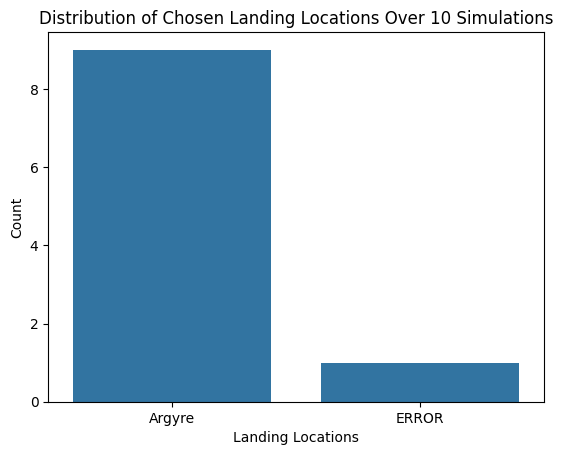

In [ ]:
# Create a bar chart of final choices
sns.countplot(x=['Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'ERROR', 'Argyre']

)
plt.xlabel("Landing Locations")
plt.ylabel("Count")
plt.title("Distribution of Chosen Landing Locations Over 10 Simulations")
plt.show()